# Implementing a Neural Network
In this exercise we will develop a neural network with fully-connected layers to perform classification, and test it out on the CIFAR-10 dataset.

In [1]:
import os
os.chdir(os.getcwd() + '/..')

# Run some setup code for this notebook
import random
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import load_CIFAR10

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from classifiers.neural_net import TwoLayerNet

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / np.maximum(1e-8, np.abs(x) + np.abs(y)))

In [3]:
# Create a small net and toy data to check implementations.
# set random seed for repeatable experiments.
input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores

In [4]:
scores = net.loss(X)
print('scores: ')
print(scores)
print

print('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print(correct_scores)
print

# The difference should be very small, get < 1e-7
print('Difference between your scores and correct scores:')
print(np.sum(np.abs(scores - correct_scores)))

scores: 
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027204961e-08


# Forward pass: compute loss

In [5]:
loss, _ = net.loss(X, y, reg=0.05)
corrent_loss = 1.30378789133

# should be very small, get < 1e-12
print('Difference between your loss and correct loss:')
print(np.sum(np.abs(loss - corrent_loss)))

Difference between your loss and correct loss:
1.79412040779e-13


classifiers/neural_net.py:74: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if y == None:


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [6]:
from utils.gradient_check import eval_numerical_gradient

loss, grads = net.loss(X, y, reg=0.05)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

b2 max relative error: 4.447687e-11
b1 max relative error: 1.555470e-09
W1 max relative error: 3.669858e-09
W2 max relative error: 3.440708e-09


# Train the network
Once you have implemented the method, run the code below to train a two-layer network on toy data. You should achieve a training loss less than 0.2.

('Final training loss: ', 0.017149607938731846)


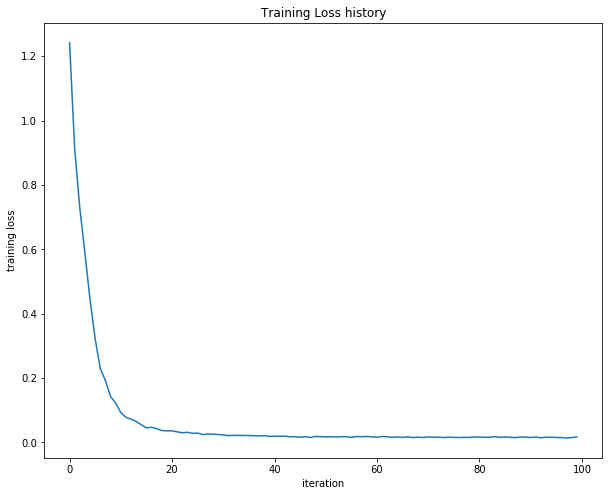

In [7]:
net = init_toy_model()
stats = net.train(X, y, X, y, learning_rate=1e-1, reg=5e-6, num_iters=100, verbose=False)
print('Final training loss: ', stats['loss_history'][-1])

# plot the loss history
plt.plot(stats['loss_history'])
plt.xlabel('iteration')
plt.ylabel('training loss')
plt.title('Training Loss history')
plt.show()

# Load the data
Now that you have implemented a two-layer network that passes gradient checks and works on toy data, it's time to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [8]:
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/cifar-10-batches-py'
X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# Split the data
num_training = 49000
num_validation = 1000
num_test = 1000

mask = range(num_training, num_training+num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

mask = xrange(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

# Preprocessing: reshape the image data into rows
X_train = X_train.reshape(X_train.shape[0], -1)
X_val = X_val.reshape(X_val.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# Normalize the data: subtract the mean rows
mean_image = np.mean(X_train, axis=0)
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image

print(X_train.shape, X_val.shape, X_test.shape)

((49000, 3072), (1000, 3072), (1000, 3072))


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [15]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
                 learning_rate=1e-4, learning_rate_decay=0.95,
                  reg=0.25, num_iters=1000, batch_size=200, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print('Validation accuracy: ', val_acc)

iteration 1 / 1000: loss 2.302957
iteration 101 / 1000: loss 2.302440
iteration 201 / 1000: loss 2.298435
iteration 301 / 1000: loss 2.262676
iteration 401 / 1000: loss 2.200829
iteration 501 / 1000: loss 2.114582
iteration 601 / 1000: loss 2.080862
iteration 701 / 1000: loss 2.099089
iteration 801 / 1000: loss 1.999965
iteration 901 / 1000: loss 1.961439
('Validation accuracy: ', 0.28599999999999998)


# Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.29 on the validation set. This isn't very good.

### One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization.

### Another strategy is to visualize the weights that were learned in the first layer of the network. In most neural networks trained on visual data, the first layer weights typically show some visible structure when visualized.

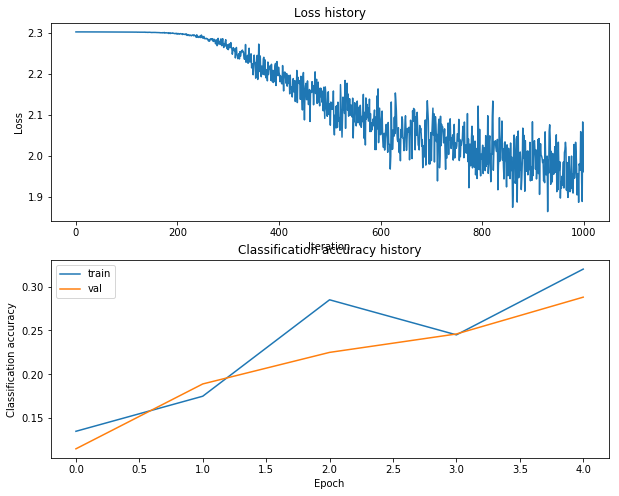

In [10]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
plt.plot(stats['train_acc_history'], label='train')
plt.plot(stats['val_acc_history'], label='val')
plt.title('Classification accuracy history')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')

plt.show()

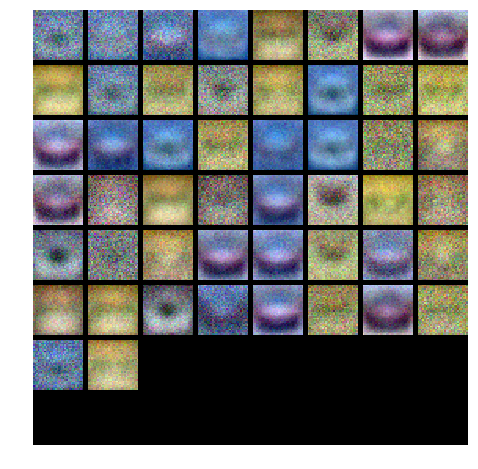

In [13]:
from utils.vis_utils import visualize_grid

# Visualize the weights of the network
def show_net_weights(net):
    W1 = net.params['W1']
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype('uint8'))
    plt.gca().axis('off')
    plt.show()
    
show_net_weights(net)

# Tune your hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including **hidden layer size, learning rate, numer of training epochs, and regularization strength**. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. For every 1% above 52% on the Test set we will award you with one extra bonus point. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [35]:
input_size = 32 * 32 * 3
num_classes = 10

hidden_layer_size = [50]
learning_rates = [3e-4, 9e-4, 1e-3, 3e-3]
regularization_strengths = [7e-1, 8e-1, 9e-1, 1]

results = {}

best_model = None
best_val = -1

for hidden_size in hidden_layer_size:
    for lr in learning_rates:
        for reg in regularization_strengths:
            model = TwoLayerNet(input_size, hidden_size, num_classes, std=1e-3)
            stats = model.train(X_train, y_train, X_val, y_val,
                             learning_rate=lr, learning_rate_decay=0.95,
                              reg=reg, num_iters=5000, batch_size=200, verbose=True)
            
            train_acc = (model.predict(X_train) == y_train).mean()
            val_acc = (model.predict(X_val) == y_val).mean()
            print('hidden_layer_size: %d, lr: %e, reg: %e, train_acc: %f, val_acc: %f' % (hidden_size, lr, reg, train_acc, val_acc))
    
            results[(hidden_size, lr, reg)] = (train_acc, val_acc)
            if val_acc > best_val:
                best_val = val_acc
                best_model = model
    print
print
     
print('best val_acc: %f' % (best_val))
    
old_lr = -1
for hidden_size, lr, reg in sorted(results):
    if old_lr != lr:
        old_lr = lr
        print
        
    train_acc, val_acc = results[(hidden_size, lr, reg)]
    print('hidden_layer_size: %d, lr: %e, reg: %e, train_acc: %f, val_acc: %f' % (hidden_size, lr, reg, train_acc, val_acc))

iteration 1 / 5000: loss 2.409961
iteration 101 / 5000: loss 2.158140
iteration 201 / 5000: loss 2.009294
iteration 301 / 5000: loss 1.979639
iteration 401 / 5000: loss 1.942002
iteration 501 / 5000: loss 1.827258
iteration 601 / 5000: loss 1.835251
iteration 701 / 5000: loss 1.704696
iteration 801 / 5000: loss 1.769029
iteration 901 / 5000: loss 1.675095
iteration 1001 / 5000: loss 1.689062
iteration 1101 / 5000: loss 1.786561
iteration 1201 / 5000: loss 1.822278
iteration 1301 / 5000: loss 1.721067
iteration 1401 / 5000: loss 1.730675
iteration 1501 / 5000: loss 1.686564
iteration 1601 / 5000: loss 1.544546
iteration 1701 / 5000: loss 1.619521
iteration 1801 / 5000: loss 1.678234
iteration 1901 / 5000: loss 1.666344
iteration 2001 / 5000: loss 1.637763
iteration 2101 / 5000: loss 1.687455
iteration 2201 / 5000: loss 1.479651
iteration 2301 / 5000: loss 1.572565
iteration 2401 / 5000: loss 1.578272
iteration 2501 / 5000: loss 1.612838
iteration 2601 / 5000: loss 1.767758
iteration 270

In [36]:
for hidden_size, lr, reg in sorted(results):
    train_acc, val_acc = results[(hidden_size, lr, reg)]
    print('hidden_layer_size: %d, lr: %e, reg: %e, train_acc: %f, val_acc: %f' % (hidden_size, lr, reg, train_acc, val_acc))

hidden_layer_size: 50, lr: 3.000000e-04, reg: 7.000000e-01, train_acc: 0.500429, val_acc: 0.485000
hidden_layer_size: 50, lr: 3.000000e-04, reg: 8.000000e-01, train_acc: 0.500510, val_acc: 0.482000
hidden_layer_size: 50, lr: 3.000000e-04, reg: 9.000000e-01, train_acc: 0.494612, val_acc: 0.486000
hidden_layer_size: 50, lr: 3.000000e-04, reg: 1.000000e+00, train_acc: 0.494184, val_acc: 0.487000
hidden_layer_size: 50, lr: 9.000000e-04, reg: 7.000000e-01, train_acc: 0.533082, val_acc: 0.495000
hidden_layer_size: 50, lr: 9.000000e-04, reg: 8.000000e-01, train_acc: 0.529490, val_acc: 0.499000
hidden_layer_size: 50, lr: 9.000000e-04, reg: 9.000000e-01, train_acc: 0.523714, val_acc: 0.489000
hidden_layer_size: 50, lr: 9.000000e-04, reg: 1.000000e+00, train_acc: 0.514755, val_acc: 0.487000
hidden_layer_size: 50, lr: 1.000000e-03, reg: 7.000000e-01, train_acc: 0.530490, val_acc: 0.506000
hidden_layer_size: 50, lr: 1.000000e-03, reg: 8.000000e-01, train_acc: 0.527694, val_acc: 0.496000
hidden_lay

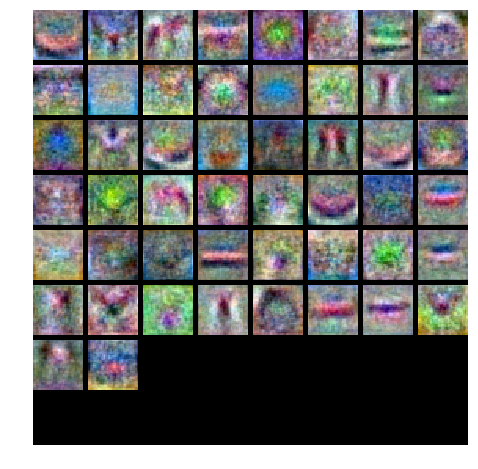

In [37]:
# visualize the weights of the best network
show_net_weights(best_model)

# Run on the test set
When you are done experimenting, you should evaluate your final trained network on the test set; you should get above 48%.

**We will give you extra bonus point for every 1% of accuracy above 52%.**

In [39]:
test_acc = (best_model.predict(X_test) == y_test).mean()
print('Test accuracy: ', test_acc)

('Test accuracy: ', 0.504)
